In [37]:
from dataclasses import dataclass
from datetime import datetime

import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [38]:
batch_size = 256

nz = 100 
ngf = 32 
ngpu = 1

niter = 100

prefix = f"fuzzy_gan_anomaly_detection"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load MNIST

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [40]:
def get_target_and_mask(target_label):
    """
    Args:
    
    Returns:
    
    """
    
    t = torch.zeros(10)
    t[target_label] = 1.0
    
    return t.to(device) 

In [41]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(train_data)

60000

In [42]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

In [43]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)


### Load EMNIST

In [44]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.zip")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]

len(emnist_x)

emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))

emnist_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.stack(emnist_x), torch.Tensor(np.array(emnist_y))), 
    batch_size=batch_size, 
    shuffle=False,
)

/tmp/ipykernel_1802685/58620865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]


## DCGAN Model

In [45]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [46]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
#netG.load_state_dict(torch.load('weights/netG_epoch_99.pth'))
print(netG)

Number of parameters: 3,573,696
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bia

In [70]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, 1, 2, 1, 1, bias=False),
            # nn.BatchNorm2d(1),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(1, 1, 2, 2, 0, bias=False),
            # nn.BatchNorm2d(1),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(1, 1, 2, 2, 0, bias=False),
            # nn.BatchNorm2d(1),
            nn.Flatten(),
            #FuzzyLayer.from_dimensions(9, 10),
            #nn.Linear(9, 2),
            #nn.BatchNorm1d(2),
            #DefuzzyLinearLayer.from_dimensions(100, 1, with_norm=False)
            
            #DefuzzyLinearLayer.from_dimensions(20, 1, with_norm=False)
            #nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            #nn.Sigmoid()
        )
        self.fuzzlets = 8
        self.fuzzy = []
        for _ in range(self.fuzzlets):
            tmp_fz = nn.Sequential(
                FuzzyLayer.from_dimensions(2, 10),
                nn.BatchNorm1d(10),
                #nn.Softmax(1)
            )
            tmp_fz.to(device)
            self.fuzzy.append(tmp_fz)

    def forward(self, input):
        output = self.main(input)
        f_inp = output.split(2, dim=1)
        fz = []
        for i in range(self.fuzzlets):
            fz.append(self.fuzzy[i](f_inp[i]).max(1).values)
        
        cmb = torch.stack(fz, dim=1)
        df = cmb.mean(dim=1)
        return df.squeeze()
    
    def arate(self, input):
        return self.forward(input)
    

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
num_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
print(netD)

Number of parameters: 658,176
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
)


In [72]:
inp = torch.rand(10, 1, 28, 28).to(device)
dd = Discriminator(1).to(device)

dd(inp).shape

torch.Size([10])

## Train

In [73]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label =  0
fake_label = 1

In [74]:
def criterionD(predicted, target):
    mod = torch.square(predicted)
    cap_real = -mod.log().mean()
    cap_fake =  mod.log().mean()

    retval = torch.where(target == real_label, cap_real, cap_fake)

    return retval.mean()
    
def criterionG(predicted, epoch):
    cap_g = torch.abs(predicted)
    
    return -cap_g.log().max()
         #+ torch.square(predicted[:, fake_label] - 0.5).mean()#-torch.clamp(predicted, 0.0, 1.0).log().max()

In [75]:
def get_test_arate_distr(D):
    firing_levels = []
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, _ in tqdm(test_loader, desc='Test MNIST'):
            data = data.view((-1,1,28,28)).to(device)
            rates = D.arate(data)
            firing_levels.append(rates.cpu().numpy())
            

    firing_levels = np.concatenate(firing_levels, axis=0)
    for p in firing_levels:
        lab_true.append(1)
        lab_pred.append(p)

    with torch.no_grad():
        for data, labels in tqdm(emnist_loader, desc='Test EMNIST'):
            data = data.view((-1, 1, 28, 28)).to(device) 
            arate = D.arate(data)
            
            for p in arate.cpu().numpy():
                lab_true.append(0)
                lab_pred.append(p)
                
    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)

    return firing_levels, roc_auc

In [76]:
for epoch in range(niter):

    netG.train()
    netD.train()
    report_loss_G = 0
    report_loss_D = 0
    local_count = 0
    for i, data in enumerate(tqdm(train_loader, desc='Training')):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterionD(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterionD(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        #torch.nn.utils.clip_grad_norm_(netD.parameters(), 1)
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        output = netD(fake)
        errG = criterionG(output, epoch)
        errG.backward()
        D_G_z2 = output.mean().item()
        #torch.nn.utils.clip_grad_norm_(netG.parameters(), 1)
        optimizerG.step()
        report_loss_G += errG.item()

        local_count += 1
        report_loss_D += errD.item()
        
        
    netG.eval()
    netD.eval()

    losses = {}
    losses['Loss D'] = report_loss_D / local_count
    losses['Loss G'] = report_loss_G / local_count
    writer.add_scalars('Loss', losses, epoch)
    fake = netG(fixed_noise)
    writer.add_images('Generated images', fake.detach(), epoch)
    mnist_distr, auc = get_test_arate_distr(netD)
    mnist_distr_q = {}
    mnist_distr_q["q20"] = np.quantile(mnist_distr, 0.2)
    mnist_distr_q["q80"] = np.quantile(mnist_distr, 0.8)
    writer.add_scalars("MNIST test  firings", mnist_distr_q, epoch)
    writer.add_scalar("AUC", auc, epoch)
    print(f"Epoch {epoch}/{niter}")

    
num_gpu = 1 if torch.cuda.is_available() else 0

Training:   0%|          | 0/235 [00:00<?, ?it/s]

## Валидация

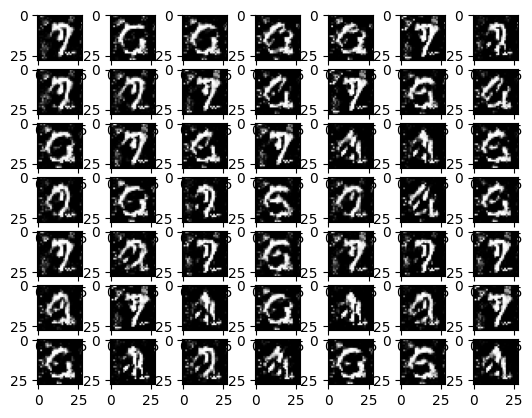

In [ ]:
D = netD
G = netG
D.eval()
G.eval()

batch_size = 49
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 7, 7
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

In [ ]:
centroids_fz =[a[0].A.cpu().detach().numpy()[:,:,2] for a in D.fuzzy]
centroids_fz

[array([[ 0.8788379 ,  0.59552854],
        [-0.35787243,  0.6540311 ],
        [ 0.28274962, -0.9976905 ],
        [-1.8469238 , -0.76821995],
        [ 0.18214212, -1.1339914 ],
        [-0.4400473 , -2.3727124 ],
        [ 1.2210152 ,  0.9829705 ],
        [ 2.045124  ,  0.9934017 ],
        [-0.3613411 ,  0.00883533],
        [-1.6015301 , -1.1826322 ]], dtype=float32),
 array([[-0.0354775 ,  1.2972318 ],
        [-0.5386473 , -0.7358808 ],
        [ 1.2640678 , -0.47657797],
        [ 0.19498277, -0.62691206],
        [-0.40966064,  0.24391006],
        [-0.6973387 , -0.33220354],
        [-0.8549079 ,  0.667338  ],
        [-1.7322339 , -0.19029817],
        [-0.13963343, -1.71017   ],
        [-0.47829345, -0.6912274 ]], dtype=float32),
 array([[ 1.692306  , -0.54813784],
        [-0.47401908, -0.02987248],
        [ 0.51314545, -0.6946    ],
        [ 0.30130148,  1.4896973 ],
        [ 0.26538524,  1.4088982 ],
        [-1.2411132 , -0.5961778 ],
        [-0.02173545,  0.17189

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

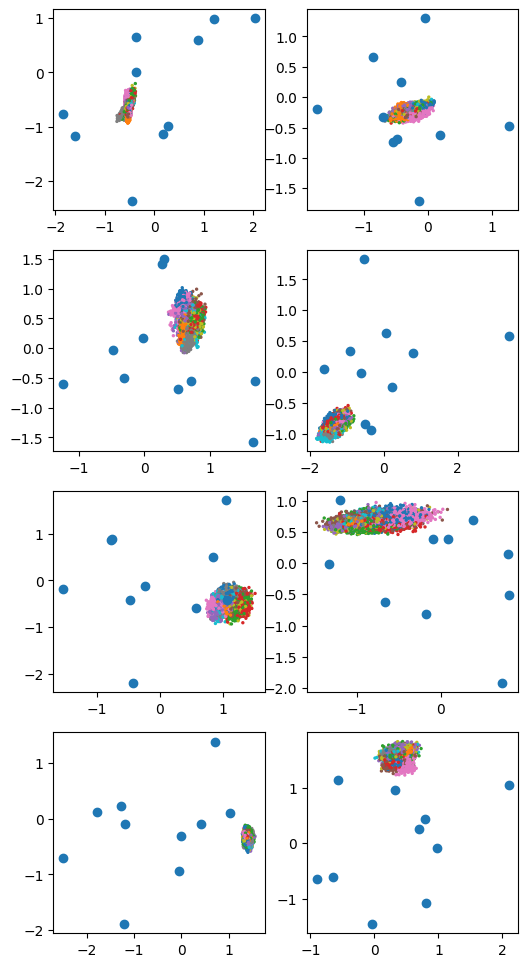

In [ ]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
plt.figure(figsize=(6, 12))

R, C = 4, 2
cnt = 1
for i in range(8):
    plt.subplot(R, C, cnt)
    cnt += 1
    plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
    plt.scatter(centroids_fz[i][:,0], centroids_fz[i][:,1])
#plt.colorbar()
plt.show()



In [ ]:
embedings

array([[-0.47940752, -0.6395125 , -0.44114146, ..., -0.39958778,
         0.331957  ,  1.6657598 ],
       [-0.49133703, -0.5579975 , -0.26592618, ..., -0.23610404,
         0.4604085 ,  1.4768028 ],
       [-0.54722834, -0.86250395, -0.4789934 , ..., -0.35505402,
         0.4615068 ,  1.6795602 ],
       ...,
       [-0.5274926 , -0.64966726, -0.31659025, ..., -0.42638588,
         0.4356925 ,  1.6344392 ],
       [-0.5186355 , -0.76929444, -0.45262688, ..., -0.29704452,
         0.46342874,  1.646973  ],
       [-0.45517468, -0.6062142 , -0.00619986, ..., -0.29960462,
         0.5087414 ,  1.4507061 ]], dtype=float32)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

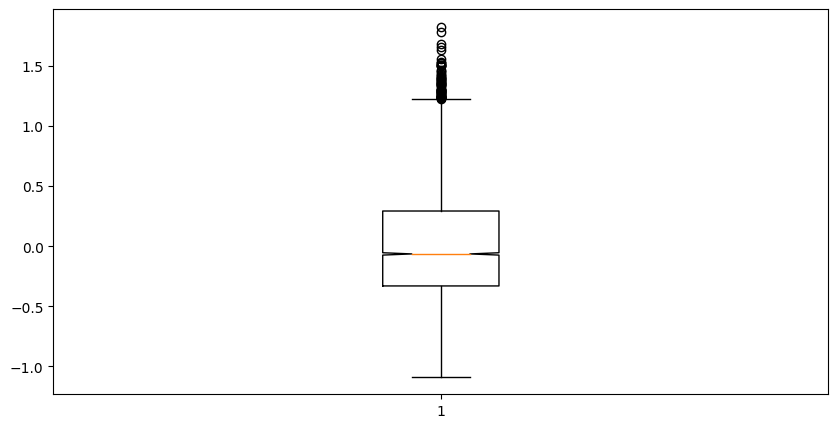

In [ ]:
firing_levels = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        rates = D.arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #rates = r

        firing_levels.append(rates.cpu().numpy())
        
firing_levels = np.concatenate(firing_levels, axis=0)
fig = plt.figure(figsize =(10, 5))
plt.boxplot(firing_levels, notch=True, showfliers=True)
plt.show()

In [ ]:
firings_emnist = {}
for m in emnist_mapping:
    firings_emnist[emnist_mapping[m]] = []

with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = D.arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #arate = 1 - r.sum(dim = 1)
        
        for label, flabel in zip(labels, arate.cpu().numpy()):
            firings_emnist[emnist_mapping[label.item()]].append(flabel)

Encoding:   0%|          | 0/405 [00:00<?, ?it/s]

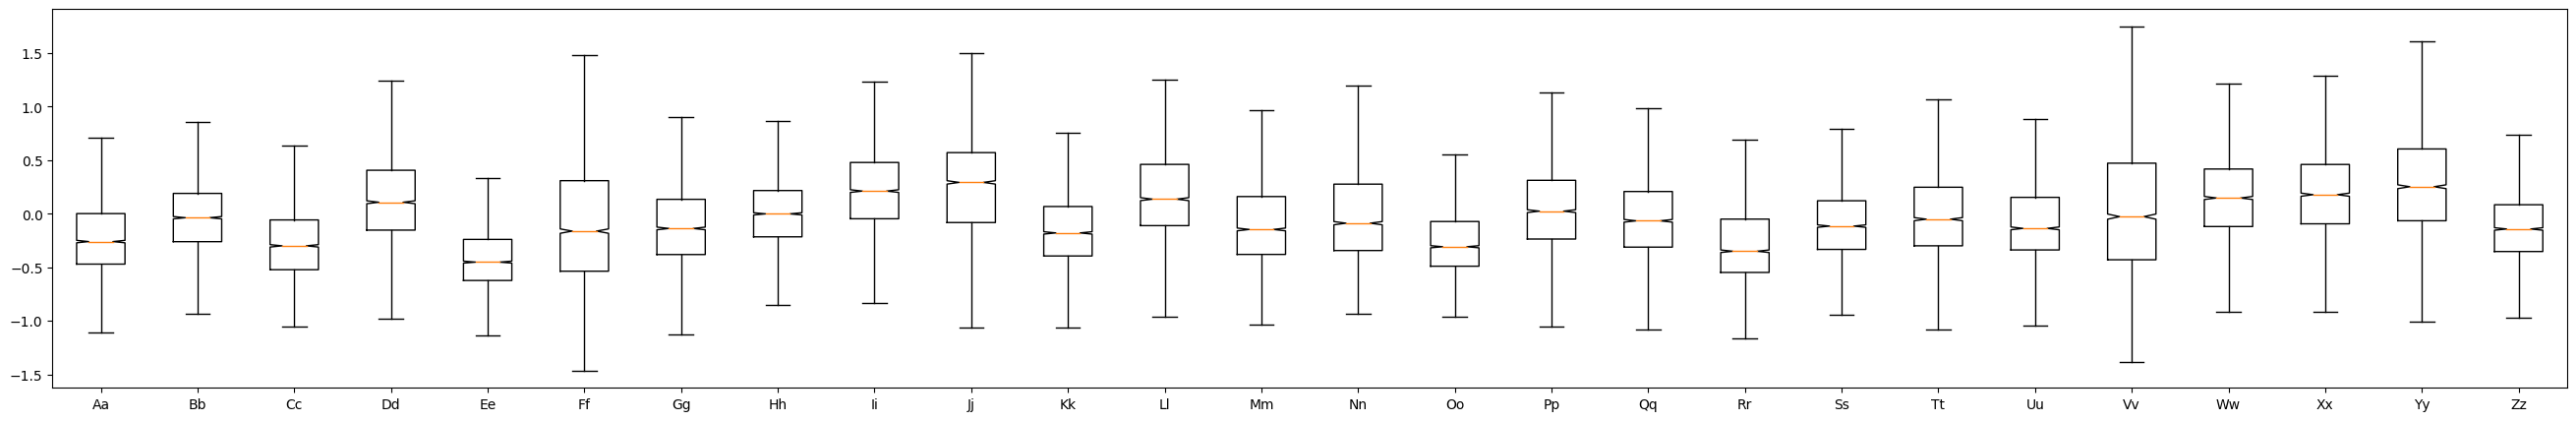

In [ ]:
labels, data = firings_emnist.keys(), firings_emnist.values()
fig = plt.figure(figsize =(33, 5))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

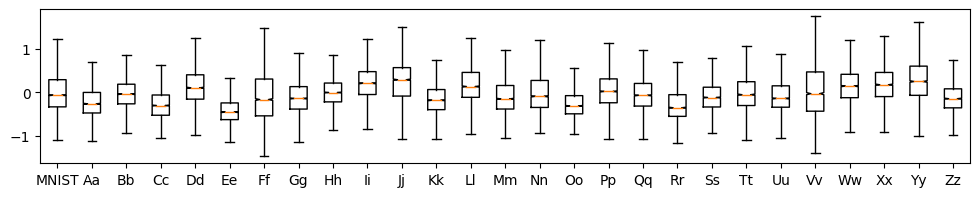

In [ ]:
firings_mnist = {}
firings_mnist['MNIST'] = firing_levels
firings = {**firings_mnist, **firings_emnist} 
labels, data = firings.keys(), firings.values()

fig = plt.figure(figsize =(12, 2))
#plt.ylim(ymin=0)
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

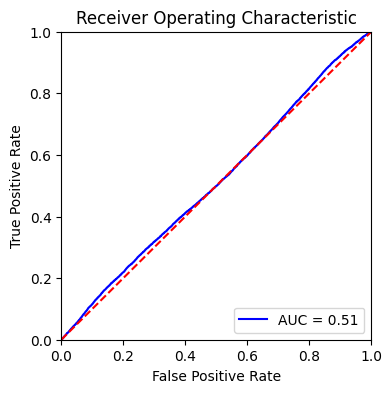

In [ ]:
lab_true = []
lab_pred = []
for k,v in firings_mnist.items():
    for p in v:
        lab_true.append(1)
        lab_pred.append(p)
for k,v in firings_emnist.items():
    if k == 'Oo':
        continue
    for p in v:
        lab_true.append(0)
        lab_pred.append(p)

fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize =(4, 4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
writer.add_figure('ROC', fig)